In [1]:
import pandas as pd
import numpy as np
import panel as pn
from matplotlib.figure import Figure
from matplotlib.ticker import MultipleLocator

pn.extension()

# Load Data

In [2]:
df = (
    pd.read_csv("timing.csv")
    .pipe(
        lambda x: x.assign(Q_p=np.log2(x.len_Q).astype(np.int64))
    )
    .pipe(
        lambda x: x.assign(T_p=np.log2(x.len_T).astype(np.int64))
    )
    .groupby(['module', 'len_Q']).filter(lambda x: len(x) >= 2)
)
pyfftw_df = df.query('module == "pyfftw"')
df = df.query('module != "pyfftw"')

# Create Interactive Plot(s)

In [3]:
GLOBAL_FIG = Figure()

In [4]:
def get_fig(mod_vals, Q_len_vals, T_p_vals):
    fig = GLOBAL_FIG  # Use global figure
    fig.clf()
    
    T_p_min, T_p_max = T_p_vals

    nplots = len(Q_len_vals)
    if nplots > 1:
        ncols = 2
    else:
        ncols = 1
    nrows = (nplots // ncols)
    if nplots % ncols > 0:
        nrows += 1

    height_factor = 1 + nplots // 3
    fig.set_size_inches(14, 6 * height_factor)
    axs = fig.subplots(max(1, nrows), max(1, ncols))

    idx = 0
    if len(mod_vals) > 0 and len(Q_len_vals) > 0:
        for Q_len in sorted(Q_len_vals):
            if nplots > 1:
                row = idx // ncols
                col = idx % ncols
                try:
                    ax = axs[row, col]
                except:
                    ax = axs[idx]
            else:
                ax = axs

            ax.set_xlabel('log2(len(T))')
            ax.set_ylabel('Time')
            ax.xaxis.set_major_locator(MultipleLocator(1))
            
            for mod in mod_vals:
                plot_df = (
                    df.query('module == @mod')
                    .query('len_Q == @Q_len')
                    .query('T_p >= @T_p_min')
                    .query('T_p <= @T_p_max')
                    .loc[:, ['T_p', 'time']]
                    .set_index('T_p')
                    .merge(
                        (
                            pyfftw_df.query("len_Q == @Q_len")
                            .query('T_p >= @T_p_min')
                            .query('T_p <= @T_p_max')
                            .loc[:, ['T_p', 'time']]
                            .set_index('T_p')
                        ),
                        left_index=True,
                        right_index=True,
                    )
                    .pipe(
                        lambda x: x.assign(time=x.time_y / x.time_x)
                    )
                )

                ax.plot(
                    plot_df.time,
                    label=f'{mod} {Q_len}'
                )

            ax.legend()
            xmin, xmax = ax.get_xlim()
            ax.set_xlim(xmin, xmax)
            ax.hlines(1.0, xmin, xmax, color='black', lw=1.0, linestyles='dashed')
            ax.hlines(0.5, xmin, xmax, color='black', lw=0.5, linestyles='dotted')
            ymin, ymax = ax.get_ylim()
            ax.set_ylim(0, ymax)
            
            idx += 1

    return fig

Column
    [0] Row
        [0] CheckButtonGroup(options=['njit', 'numpy_fft', ...], value=['njit', 'numpy_fft', ...])
        [1] IntRangeSlider(end=np.int64(28), start=np.int64(6), value=(np.int64(6), ..., value_end=np.int64(28), value_start=np.int64(6))
    [1] Row
        [0] Column
            [0] Button(button_type='primary', name='All')
            [1] CheckBoxGroup(options=[64, 128, 256, ...], value=[64, 128, 256, ...])
        [1] Matplotlib(Figure, dpi=100, tight=True)
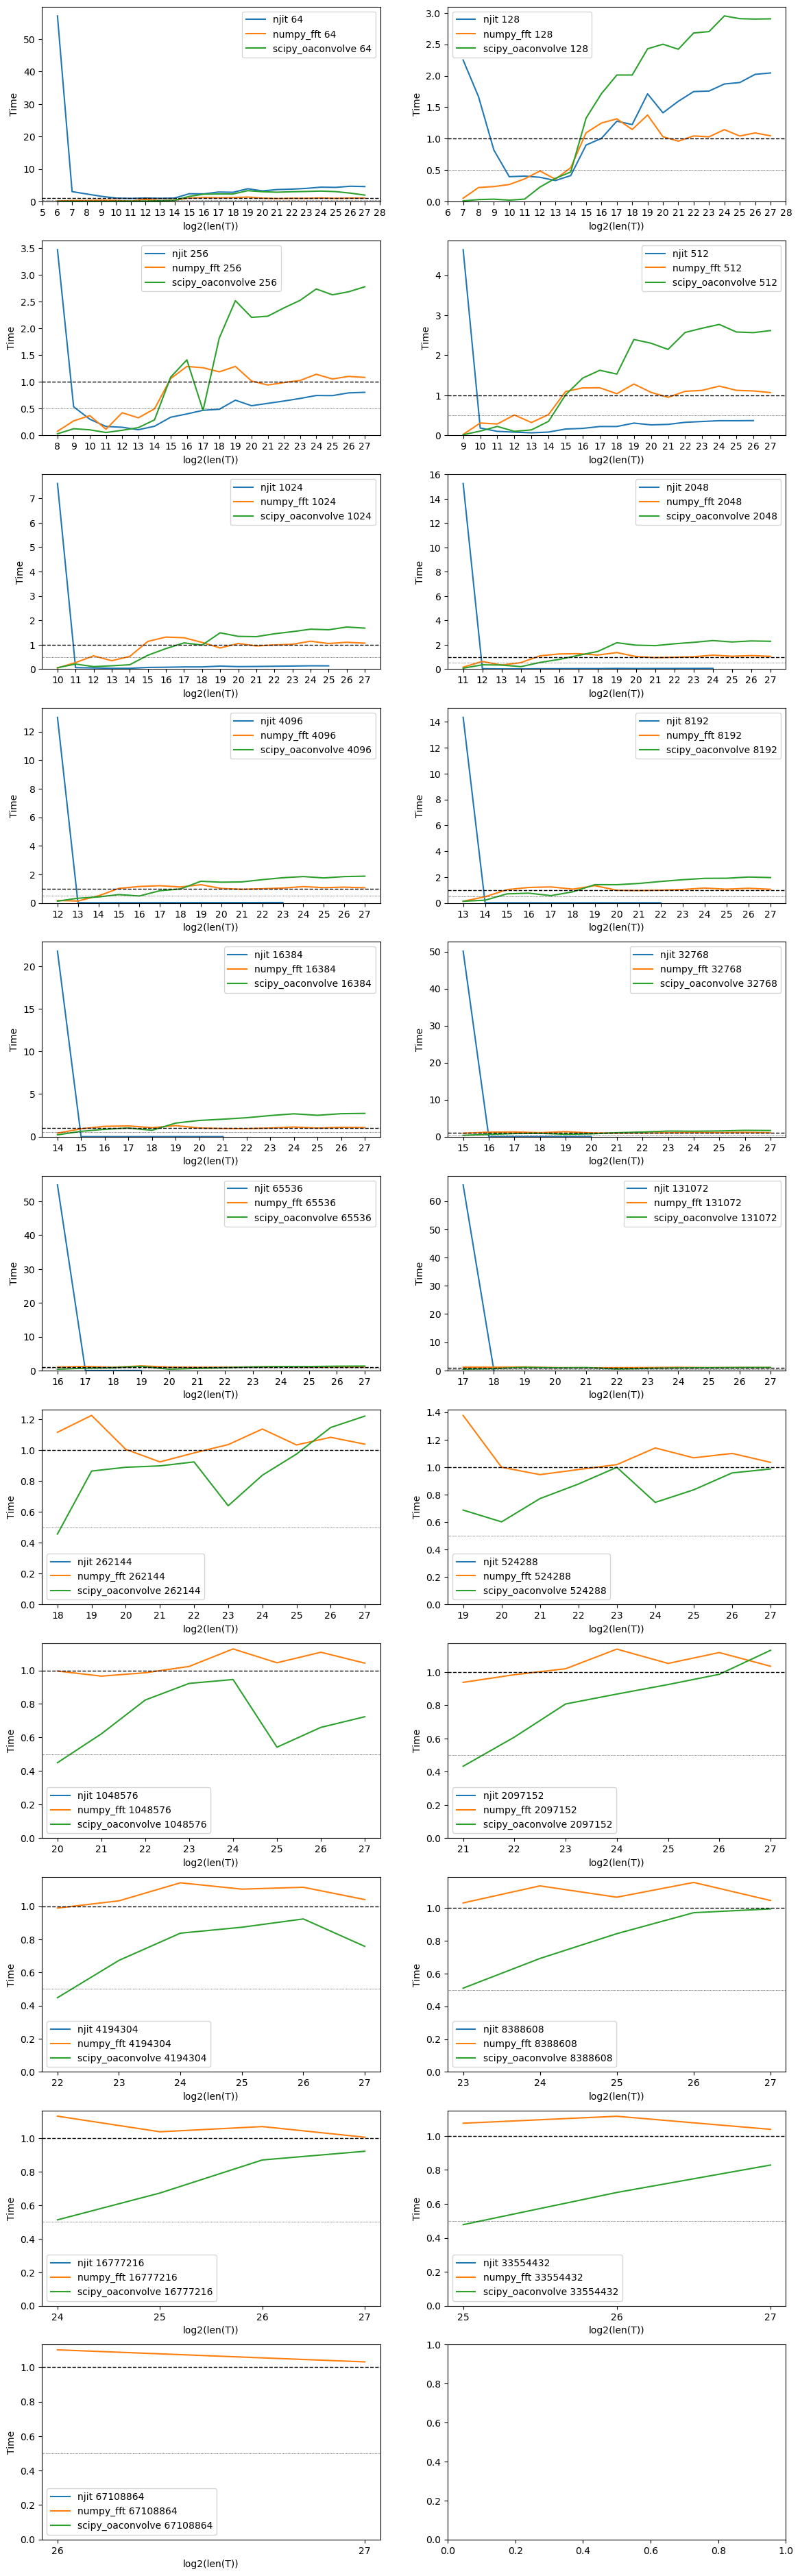

In [5]:
# Select default widget values
mod_vals = df.module.unique().tolist()
Q_LEN_ALL_VALS = df.len_Q.unique().tolist()
Q_len_vals = Q_LEN_ALL_VALS
T_p_min, T_p_max = df.T_p.unique().min(), df.T_p.unique().max()

# Create plot
plot = pn.pane.Matplotlib(get_fig(mod_vals, Q_len_vals, (T_p_min, T_p_max)), dpi=100, tight=True)

# Create widgets with default values
mod_widget = pn.widgets.CheckButtonGroup(value=mod_vals, options=df.module.unique().tolist())
all_widget = pn.widgets.Button(name='All', button_type='primary')
Q_len_widget = pn.widgets.CheckBoxGroup(value=Q_len_vals, options=Q_len_vals)
T_p_widget = pn.widgets.IntRangeSlider(start=T_p_min, end=T_p_max, value=(T_p_min, T_p_max), step=1)

# Create function to update plot
@pn.depends(mod_widget, Q_len_widget, T_p_widget, watch=True)
def update(mod_vals, Q_len_vals, T_len_vals):
    get_fig(mod_vals, Q_len_vals, T_len_vals)
    plot.param.trigger("object")

def toggle_all(event):
    if all_widget.clicks % 2 != 0:
        all_widget.button_style = 'outline'
        Q_len_widget.value = []
    else:
        all_widget.button_style = 'solid'
        Q_len_widget.value = Q_LEN_ALL_VALS

all_widget.on_click(toggle_all)

dashboard = pn.Column(pn.Row(mod_widget, T_p_widget), pn.Row(pn.Column(all_widget, Q_len_widget), plot))
dashboard.servable()